In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
import os
from tqdm import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
sn.set(font_scale=1.4)
%matplotlib inline

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)

In [3]:
def load_data():
    datasets = ['./datasets/seg_train/seg_train', './datasets/seg_test/seg_test']
    output = []
    for dataset in datasets:
        images = []
        labels = []
        print("Loading: {}".format(dataset))
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype=np.float32)
        labels = np.array(labels, dtype=np.int32)
        
        output.append((images, labels))
    return output

In [4]:
(X_train, y_train), (X_test, y_test) = load_data()

Loading: ./datasets/seg_train/seg_train


100%|██████████████████████████████████████████████████████████████████████████████| 2382/2382 [00:25<00:00, 94.89it/s]


Loading: ./datasets/seg_test/seg_test


100%|████████████████████████████████████████████████████████████████████████████████| 501/501 [00:06<00:00, 81.06it/s]


In [5]:
X_train, y_train = shuffle(X_train, y_train, random_state=25)

In [6]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


In [7]:
X_train.shape

(14034, 150, 150, 3)

<AxesSubplot:>

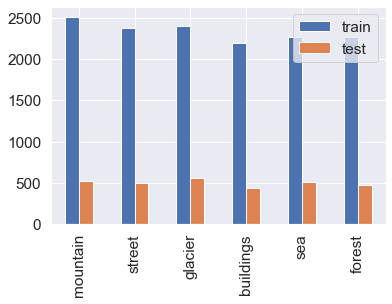

In [8]:
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts, 'test': test_counts},
            index=class_names).plot.bar()


Text(0.5, 1.0, 'Proportion of each observed category')

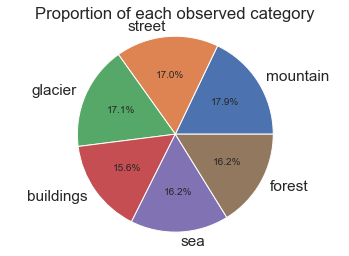

In [9]:
plt.pie(train_counts, explode=(0, 0, 0, 0, 0, 0),
       labels=class_names,
       autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')

In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])

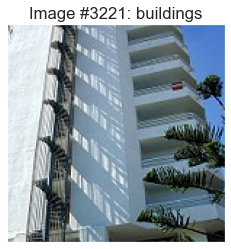

In [12]:
display_random_image(class_names, X_train, y_train)

In [13]:
def display_examples(class_names, images ,labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle('Some examples of images of dataset', fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])

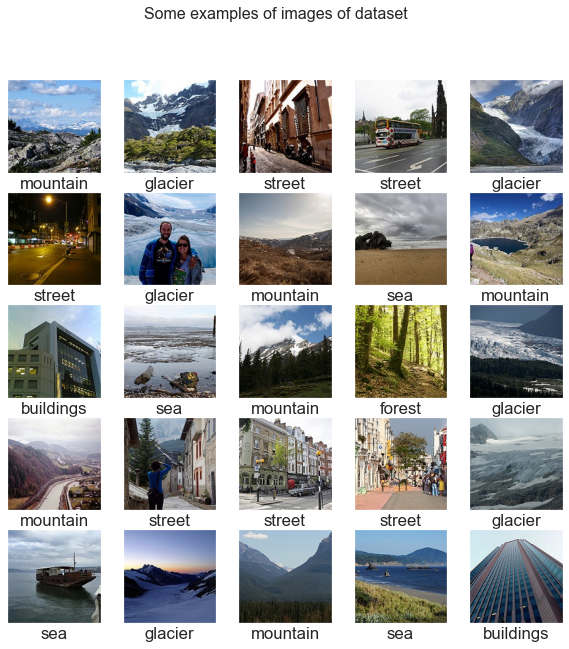

In [14]:
display_examples(class_names, X_train, y_train)

# Simple model

In [15]:
model = tf.keras.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation=tf.nn.relu),
    Dense(6, activation=tf.nn.softmax)
])

In [16]:
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5308544   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 7

In [18]:
history = model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.2)

Epoch 1/3
88/88 [==============================] - 349s 4s/step - loss: 1.1045 - accuracy: 0.5791 - val_loss: 0.8788 - val_accuracy: 0.6808
Epoch 2/3
88/88 [==============================] - 330s 4s/step - loss: 0.7317 - accuracy: 0.7324 - val_loss: 0.8193 - val_accuracy: 0.6886
Epoch 3/3
88/88 [==============================] - 257s 3s/step - loss: 0.5331 - accuracy: 0.8115 - val_loss: 0.6688 - val_accuracy: 0.7656


In [19]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))
    
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label='acc')
    plt.plot(history.history['val_accuracy'], 'ro--', label='val_acc')
    plt.title('train_acc vs val_acc')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label='loss')
    plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
    plt.title('train_loss vs val_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    

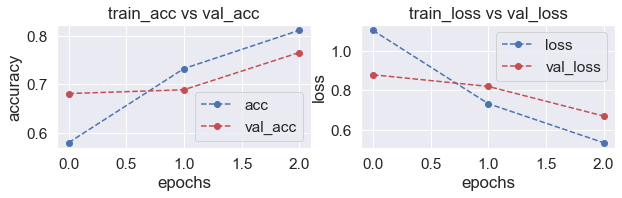

In [20]:
plot_accuracy_loss(history)

In [21]:
test_loss = model.evaluate(X_test, y_test)

94/94 [==============================] - 21s 227ms/step - loss: 0.6973 - accuracy: 0.7443


In [22]:
predictions = model.predict(X_test)
pred_labels = np.argmax(predictions, axis=1)

Text(0.5, 1.0, 'Confusion matrix')

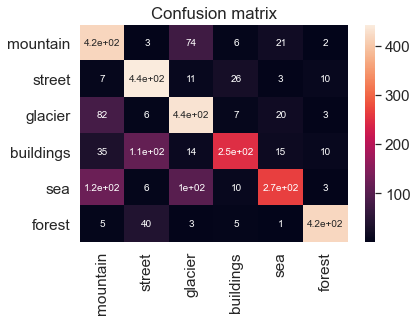

In [23]:
CM = confusion_matrix(y_test, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, annot_kws={'size': 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, 
           ax=ax)
ax.set_title('Confusion matrix')

In [24]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [25]:
train_features = model.predict(X_train)
test_features = model.predict(X_test)

In [85]:
model2 = VGG16(weights='imagenet', include_top=False)

In [86]:
input_shape = model2.layers[-4].get_input_shape_at(0)
layer_input = Input(shape=(9, 9, 512))

In [96]:
x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
x = Conv2D(64, (3,3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

new_model = Model(layer_input, x)
new_model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [97]:
new_model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 9, 9, 512)]       0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 2, 2, 64)          294976    
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 2, 64)        

In [98]:
history = new_model.fit(train_features, y_train, batch_size=128, epochs=5, validation_split=0.2)

Epoch 1/5
88/88 [==============================] - 590s 7s/step - loss: 0.7171 - accuracy: 0.7227 - val_loss: 0.3908 - val_accuracy: 0.8650
Epoch 2/5
88/88 [==============================] - 651s 7s/step - loss: 0.3637 - accuracy: 0.8753 - val_loss: 0.4512 - val_accuracy: 0.8504
Epoch 3/5
88/88 [==============================] - 581s 7s/step - loss: 0.2884 - accuracy: 0.9008 - val_loss: 0.5505 - val_accuracy: 0.8215
Epoch 4/5
88/88 [==============================] - 632s 7s/step - loss: 0.2396 - accuracy: 0.9178 - val_loss: 0.3589 - val_accuracy: 0.8810
Epoch 5/5
88/88 [==============================] - 649s 7s/step - loss: 0.2077 - accuracy: 0.9293 - val_loss: 0.3204 - val_accuracy: 0.8846


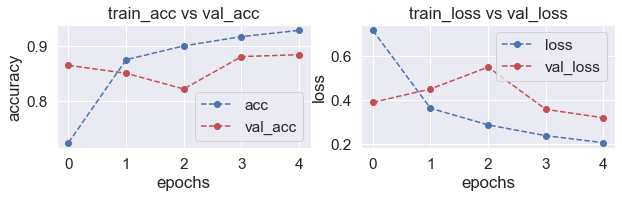

In [99]:
plot_accuracy_loss(history)

In [102]:
predictions = new_model.predict(test_features)
y_pred = np.argmax(predictions, axis=-1)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.884


Text(0.5, 1.0, 'Confusion matrix')

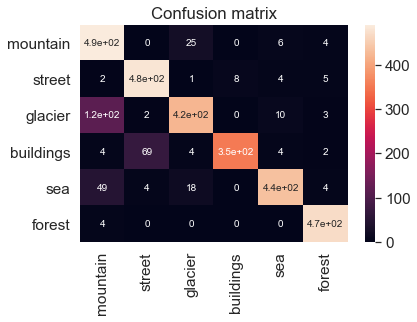

In [104]:
CM = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sn.heatmap(CM, annot=True, annot_kws={'size': 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, 
           ax=ax)
ax.set_title('Confusion matrix')

In [106]:
test_loss = new_model.evaluate(test_features, y_test)

94/94 [==============================] - 48s 512ms/step - loss: 0.3159 - accuracy: 0.8840


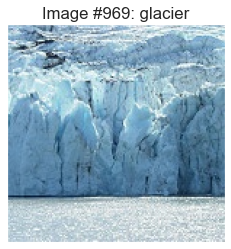

In [108]:
display_random_image(class_names, X_test, y_pred)

In [112]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    mislabeled_image_condition = (test_labels == pred_labels)
    mislabeled_indices = np.where(mislabeled_image_condition == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    
    title = 'Some mislabeled images by the classifier: '
    display_examples(class_names, mislabeled_images, mislabeled_labels)

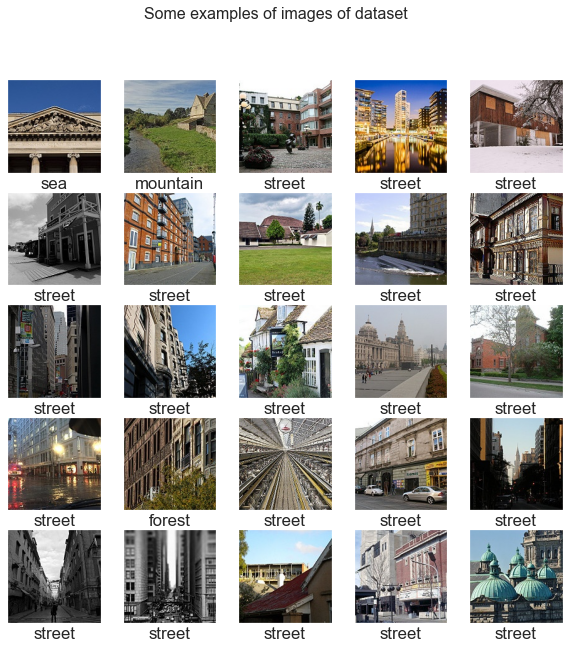

In [113]:
print_mislabeled_images(class_names, X_test, y_test, y_pred)

# Conclusion

- The simple architectures get quite good performace but still underfitting (val_acc = 0.766) after 3 epochs, it can be solved by more epochs than only 3
- The transfer learning by using fine tuning VGG16 makes more performace with high accuracy.